In [34]:
# Notebook investigating using the mca
#https://github.com/bluesky/ophyd/blob/master/ophyd/mca.py

In [9]:
from ophyd.mca import EpicsMCA, ROI

from ophyd import EpicsSignal, EpicsSignalRO
from ophyd import status, DeviceStatus, Signal
from ophyd.status import SubscriptionStatus, MoveStatus, AndStatus 
from collections import OrderedDict

from ophyd.device import (Device, Component as Cpt, DynamicDeviceComponent as DDC,
                     Kind)

class ROI(Device):

    # 'name' is not an allowed attribute
    label = Cpt(EpicsSignal, 'NM', lazy=True, kind='config')
    count = Cpt(EpicsSignalRO, '', lazy=True)
    net_count = Cpt(EpicsSignalRO, 'N', lazy=True, kind='config')
    preset_count = Cpt(EpicsSignal, 'P', lazy=True, kind='config')
    is_preset = Cpt(EpicsSignal, 'IP', lazy=True, kind='config')
    bkgnd_chans = Cpt(EpicsSignal, 'BG', lazy=True, kind='config')
    hi_chan = Cpt(EpicsSignal, 'HI', lazy=True, kind='config')
    lo_chan = Cpt(EpicsSignal, 'LO', lazy=True, kind='config')

    def __init__(self, prefix, *, read_attrs=None, configuration_attrs=None,
                 name=None, parent=None, **kwargs):

        super().__init__(prefix, read_attrs=read_attrs,
                         configuration_attrs=configuration_attrs,
                         name=name, parent=parent, **kwargs)


def add_rois(range_, **kwargs):
    '''Add one or more ROIs to an MCA instance
       Parameters
       ----------
       range_ : sequence of ints
           Must be be in the set [0,31]
       By default, an EpicsMCA is initialized with all 32 rois.
       These provide the following Components as EpicsSignals (N=[0,31]):
       EpicsMCA.rois.roiN.(label,count,net_count,preset_cnt, is_preset,
       bkgnd_chans, hi_chan, lo_chan)
       '''
    defn = OrderedDict()

    for roi in range_:
        if not (0 <= roi < 32):
            raise ValueError('roi must be in the set [0,31]')

        attr = 'roi{}'.format(roi)
        defn[attr] = (ROI, '.R{}'.format(roi), kwargs)

    return defn


class MyEpicsMCA(EpicsMCA):
    
    erase_start = Cpt(EpicsSignal, 'EraseStart', kind='omitted')
    acquiring = Cpt(EpicsSignal, '.ACQG', kind='omitted')
    rois = DDC(add_rois(range(0, 32)))
    
    #calibration
    offset = Cpt(EpicsSignalRO, '.CALO',kind='config')
    slope = Cpt(EpicsSignalRO, '.CALS',kind='config')
    quadratic = Cpt(EpicsSignalRO, '.CALQ',kind='config')
    egu = Cpt(EpicsSignalRO, '.EGU',kind='config')
    two_theta = Cpt(EpicsSignalRO, '.TTH',kind='config')
    
    def trigger(self):
        
        
        #variable used as an event flag
        acquisition_status = False
           
        def acquisition_started(status):
            nonlocal acquisition_status #Define as nonlocal as we want to modify it
            acquisition_status = True
                
        def check_value(*, old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.
                                   
            if not acquisition_status:  #But only report done if acquisition was already started
                
                return False
                       
            return (value == 0)
        
        # create the status with SubscriptionStatus that add's a callback to check_value.
        sta_cnt = SubscriptionStatus(self.acquiring, check_value, run=False)
         
        # Start the acquisition
        sta_acq = self.erase_start.set(1)
        
        sta_acq.add_callback(acquisition_started)
        
        stat = AndStatus(sta_cnt, sta_acq)
        
        return stat


bruker = MyEpicsMCA('SISSY2EX:SDD00:mca1',name='bruker')
bruker.wait_for_connection()

In [2]:
# Test to see if the status object that gets returned from trigger changes correctly when finished
    
from datetime import datetime
now = datetime.now().strftime("%H:%M:%S")

def callback(status):
    
    now = datetime.now().strftime("%H:%M:%S")
    print(f"{status} has completed at {now}")

bruker.enable_wait.set('Disable')
status=bruker.trigger()
now = datetime.now().strftime("%H:%M:%S")
print(f"{status} has started at {now}"  )
status.add_callback(callback)

AndStatus(done=False, success=False) has started at 18:49:06
AndStatus(done=True, success=True) has completed at 18:49:10


Now we will try with the Run Engine


In [3]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1



Transient Scan ID: 4     Time: 2021-10-01 19:08:36
Persistent Unique Scan ID: '37e27f35-c76a-4218-ae7b-864057a2d7a4'
New stream: 'primary'
+-----------+------------+------------+------------------------+
|   seq_num |       time |      motor | bruker_rois_roi0_count |
+-----------+------------+------------+------------------------+
|         1 | 19:08:38.0 |     -1.000 |                 224.00 |
|         2 | 19:08:40.4 |     -0.500 |                  36.00 |
|         3 | 19:08:41.9 |      0.000 |                  28.00 |
|         4 | 19:08:43.3 |      0.500 |                  25.00 |
|         5 | 19:08:45.9 |      1.000 |                  57.00 |
+-----------+------------+------------+------------------------+
generator scan ['37e27f35'] (scan num: 4)





('37e27f35-c76a-4218-ae7b-864057a2d7a4',)

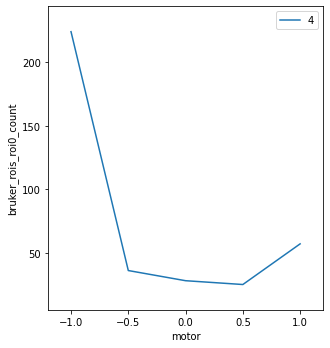

In [68]:
from bluesky.plans import count,scan
from ophyd.sim import motor

#We can define which counts we want to display. For now they are in counts and not energy, this is easy to change later
bruker.rois.roi0.count.kind = 'hinted'
RE(scan([bruker],motor,-1,1,5))

In [69]:
run = db[-1]

In [70]:
# Practice getting the config parameters from the dataset

offset = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_offset']
slope = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_slope']
quadratic = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_quadratic']
egu = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_egu']
two_theta = run.primary.metadata['descriptors'][0]['configuration']['bruker']['data']['bruker_two_theta']

print(offset,slope,quadratic,egu,two_theta)

-538.6077270507812 23.31550407409668 0.0 Wills 10.0


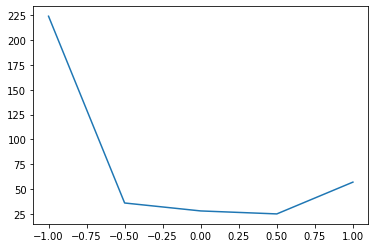

In [76]:
#Practice plotting

data = run.primary.read()
counts = data.bruker_rois_roi0_count
motor_pos = data.motor

import matplotlib.pyplot as plt


plt.plot(motor_pos,counts)



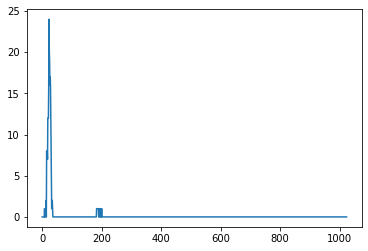

In [66]:
# And practice getting the spectra for a particular entry

import matplotlib.pyplot as plt

spectrum_at_first_sample = data.bruker_spectrum.values[0]
plt.plot(spectrum_at_first_sample)